In [1]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

## 1. Sensor with bias


The sensor is biased. In particular,
$$y_t = Cx_t + b_t + v_t,$$
where $v_t$ is meaurement noise, $b_t$ is a *bias* term which is constant or allowed to change slowly.

We can model the bias as
$$b_{t+1} = b_t + w^b_t,$$
where $w^b_t$ is a zero-mean iid Gaussian noise term. Note that ${\rm I\!E}[b_t] = {\rm I\!E}[b_{t+1}]$.

Assumption: $w^b_t \overset{\rm iid}{\sim} \mathcal{N}(0, Q^b)$ independent of $w_t$ and all other noise terms.

Let us see how $b_t$ may look like: we'll look at paths of $(b_t)_t$

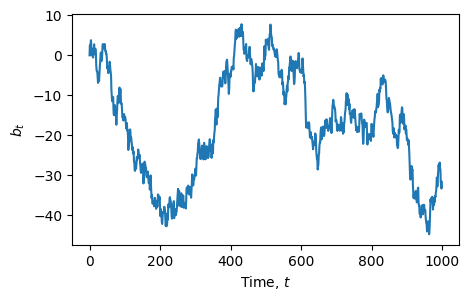

In [2]:
Qb = 2
n_sim = 1000
b_cache = np.zeros((n_sim, 1))
for i in range(n_sim - 1):
    wbi = np.random.normal(0, np.sqrt(Qb), 1)
    b_cache[i+1] = b_cache[i] + wbi

plt.figure(figsize=(5, 3))
plt.plot(b_cache)
plt.xlabel('Time, $t$')
plt.ylabel('$b_t$')
plt.show()

**Mini exercise:** Generate $r=500$ paths $(b_t)_t$ and plot them in the same figure

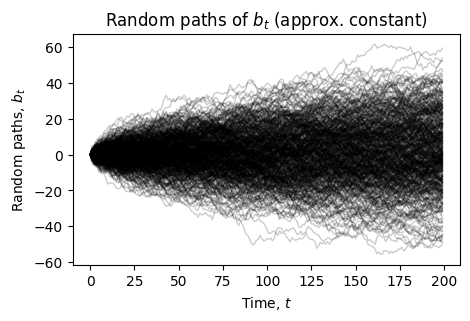

In [3]:
r = 500
n_sim = 200
b_cache = np.zeros((n_sim, r))

for i in range(r):
    for t in range(n_sim - 1):
        wbi = np.random.normal(0, np.sqrt(Qb), 1)
        b_cache[t+1, i] = b_cache[t, i] + wbi[0]

plt.figure(figsize=(5, 3))
plt.plot(b_cache, 'k', linewidth=1, alpha=0.2)
plt.xlabel('Time, $t$')
plt.ylabel('Random paths, $b_t$')
plt.title('Random paths of $b_t$ (approx. constant)')
plt.show()

**Mini exercise:** Increase $Q^b$ and see what happens.

We define the state variable $z_t = (x_t, b_t)$; we will estimate $z_t$ with a KF. The system dynamics becomes
$$\begin{align*}
        z_{t+1} = & \begin{bmatrix} A \\ & I \end{bmatrix}z_t + \tilde{w}_t,
        \\
        y_{t} =   & \begin{bmatrix} C & I \end{bmatrix}z_t + v_t,
\end{align*}$$
where $\tilde{w}_t = (w_t, w^b_t) \sim \mathcal{N}(0, \tilde{Q})$ with
$$\tilde{Q} = \begin{bmatrix}Q \\ & Q^b\end{bmatrix}.$$
We can now design a KF for this system.

More examples at https://am-press.github.io/posts/maths/kalman-6/

### 1.1. Example

Consider the system
$$\begin{aligned}
x_{t+1} =& \begin{bmatrix}0.98& -0.7 \\ 0.1& 0.9\end{bmatrix}x_t + w_t,
\\
y_t =& \begin{bmatrix}1 & 1\end{bmatrix}x_t + b_t + v_t,
\end{aligned}$$
where $w_t$ and $v_t$ satisfy the standard assumptions of the Kalman filter (which?) and have covariances $Q$ and $R$ respectively given by
$$Q = \begin{bmatrix}0.2& 0.005 \\ 0.005 & 0.001\end{bmatrix}, R = 10.$$
It is given that $\tilde{x}_0 = (0, 0)$, $P_0 = 100\cdot I$, while $\tilde{b}_0=0$ and the corresponding initial variance of $b$ is $P_0^b = 1000$. Lastly, take $Q^b = 0.1$.


In [4]:
# System data
A = np.array([[0.98, -0.7],
              [0.1, 0.9]])
C = np.array([[1, 1]])
Q = np.array([[0.2, 0.005],
              [0.005, 0.001]])
R = 10

A_tilde = sp.linalg.block_diag(A, 1)
C_tilde = np.hstack((C, [[1]]))
P0_tilde = np.diag([100, 100, 1000])
Qbar = sp.linalg.block_diag(Q, 0.1)
z0_tilde = np.zeros((3, ))

Let us now build a Kalman Filter for the system with augmented state $z_t = (x_t, b_t)$. First we need the functions `measurement_update` and `time_update`:

In [5]:
def measurement_update(sigma_tu, z_tu, y):
    t = C_tilde @ sigma_tu @ C_tilde.T + R # auxiliary variable
    z_mu = z_tu + sigma_tu @ C_tilde.T @ np.linalg.solve(t, y - C_tilde@z_tu)
    sigma_mu = sigma_tu - sigma_tu @ C_tilde.T @ np.linalg.solve(t, C_tilde@sigma_tu)
    return sigma_mu, z_mu

def time_update(sigma_mu, z_mu):
    z_tu = A_tilde @ z_mu
    sigma_tu = A_tilde @ sigma_mu @ A_tilde.T + Qbar
    return sigma_tu, z_tu

We can now run simulations with the Kalman filter...

In [6]:
n_sim = 40

z = np.random.multivariate_normal(z0_tilde, P0_tilde, 1).T # random initial state
sigma_tu, z_tu = P0_tilde, z0_tilde.reshape((3, 1)) # initialisation

z_cache = np.zeros((n_sim, 3))
z_mu_cache = np.zeros((n_sim-1, 3))
z_cache[0, :] = z0_tilde.T
for t in range(n_sim - 1):
    # i. Obtain measurement
    v = np.random.normal([0], np.sqrt(R), 1)
    y = C_tilde @ z + v

    # ii. Measurement update
    sigma_mu, z_mu = measurement_update(sigma_tu, z_tu, y)
    z_mu_cache[t, :] = z_mu.T

    # iii. Time update
    sigma_tu, z_tu = time_update(sigma_mu, z_mu)
    w = np.random.multivariate_normal([0, 0, 0], Qbar, 1).T

    # iv. System dynamics
    z = A_tilde @ z + w
    z_cache[t+1, :] = z.T

...and we can plot the results...

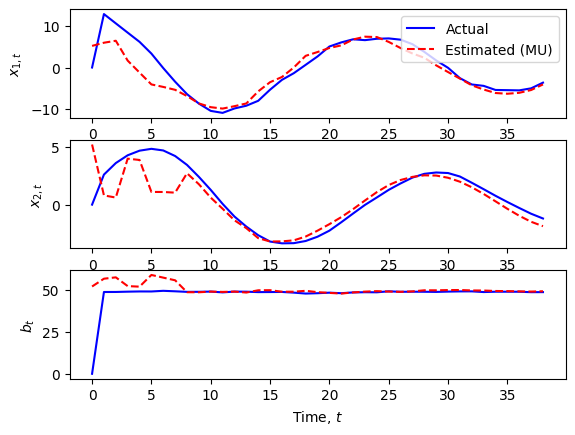

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
# first plot
ax1.plot(z_cache[:-1, 0], 'b-', label='Actual')
ax1.plot(z_mu_cache[:, 0], 'r--', label='Estimated (MU)')
ax1.set_ylabel('$x_{1, t}$')
ax1.legend(loc='upper right')
# second plot
ax2.plot(z_cache[:-1, 1], 'b-', label='Actual')
ax2.plot(z_mu_cache[:, 1], 'r--', label='Estimated (MU)')
ax2.set_ylabel('$x_{2, t}$')
# third plot: b
ax3.plot(z_cache[:-1, 2], 'b-', label='Actual')
ax3.plot(z_mu_cache[:, 2], 'r--', label='Estimated (MU)')
ax3.set_ylabel('$b_t$')
ax3.set_xlabel('Time, $t$')
plt.show()

## 2. System with drift

The dynamics of a system is affected by an unknown drift; it is
$$x_{t+1} = Ax_t + Fc_t + w_t,$$
where $c_t$ is constant or is allowed to change slowly.
Similar to what we did in Section 1 we use the model
$$c_{t+1} = c_{t} + w^c_t,$$
where $w^c_t \overset{\rm iid}{\sim} \mathcal{N}(0, Q^b)$ independent of $w_t$ and all other noise terms.

Overall, we have the system
$$\begin{align*}
    \begin{bmatrix}x_{t+1} \\ c_{t+1}\end{bmatrix}
    {}={} &
    \underbracket{\begin{bmatrix}A & F\\0 & I\end{bmatrix}}_{\tilde{A}}
    \begin{bmatrix}x_{t} \\ c_{t}\end{bmatrix}
    {}+{}
    \begin{bmatrix}w_{t} \\ w^c_{t}\end{bmatrix},
    \\
    y_t
    {}={} &
    \underbracket{\begin{bmatrix}C & 0\end{bmatrix}}_{\tilde{C}}
    \begin{bmatrix}x_{t} \\ c_{t}\end{bmatrix} + v_t,
\end{align*}$$
where
$$\begin{bmatrix}w_{t} \\ w^c_{t}\end{bmatrix}
    \sim
    \mathcal{N}
    \left(
    0,
    \begin{bmatrix}
            Q \\  & Q^c
        \end{bmatrix}
    \right).$$



### 2.1. Example
Consider the system
$$\begin{aligned}
x_{t+1} =& \begin{bmatrix}0.98& -0.7 \\ 0.1& 0.9\end{bmatrix}x_t +\begin{bmatrix}1.5 \\ 0.3\end{bmatrix}c_t + w_t,
\\
y_t =& \begin{bmatrix}1 & 1\end{bmatrix}x_t + v_t,
\end{aligned}$$
where $w_t$ and $v_t$ satisfy the standard assumptions of the Kalman filter (which?) and have covariances $Q$ and $R$ respectively given by
$$Q = \begin{bmatrix}0.2& 0.005 \\ 0.005 & 0.001\end{bmatrix}, R = 10.$$
It is given that $\tilde{x}_0 = (0, 0)$, $P_0 = 100\cdot I$, while $\tilde{c}_0=0$ and the corresponding initial variance of $c$ is $P_0^c = 1000$. Lastly, take $Q^c = 0.5$.

In [8]:
# Problem data
A = np.array([[0.98, -0.7],
              [0.1, 0.9]])
F = np.array([[1.5, 0.3]]).T
C = np.array([[1, 1]])
Q = np.array([[0.2, 0.005],
              [0.005, 0.001]])
R, Qc = 10, 0.5
z0_tilde = np.zeros((3, ))
P0_tilde = np.diag([100, 100, 1000])
Qbar = sp.linalg.block_diag(Q, Qc)
A_tilde = np.block([[A, F], [0, 0, 1]])
C_tilde = np.block([C, 0])

we can now construct the functions `time_update` and `measurement_update`

In [9]:
def measurement_update(sigma_tu, z_tu, y):
    t = C_tilde @ sigma_tu @ C_tilde.T + R # auxiliary variable
    z_mu = z_tu + sigma_tu @ C_tilde.T @ np.linalg.solve(t, y - C_tilde@z_tu)
    sigma_mu = sigma_tu - sigma_tu @ C_tilde.T @ np.linalg.solve(t, C_tilde@sigma_tu)
    return sigma_mu, z_mu

def time_update(sigma_mu, z_mu):
    z_tu = A_tilde @ z_mu
    sigma_tu = A_tilde @ sigma_mu @ A_tilde.T + Qbar
    return sigma_tu, z_tu

...and we can run simulations with the KF...

In [10]:
n_sim = 40

z = np.random.multivariate_normal(z0_tilde, P0_tilde, 1).T # random initial state
sigma_tu, z_tu = P0_tilde, z0_tilde.reshape((3, 1)) # initialisation

z_cache = np.zeros((n_sim, 3))
z_mu_cache = np.zeros((n_sim-1, 3))
z_cache[0, :] = z0_tilde.T
for t in range(n_sim - 1):
    # i. Obtain measurement
    v = np.random.normal([0], np.sqrt(R), 1)
    y = C_tilde @ z + v

    # ii. Measurement update
    sigma_mu, z_mu = measurement_update(sigma_tu, z_tu, y)
    z_mu_cache[t, :] = z_mu.T

    # iii. Time update
    sigma_tu, z_tu = time_update(sigma_mu, z_mu)
    w = np.random.multivariate_normal([0, 0, 0], Qbar, 1).T

    # iv. System dynamics
    z = A_tilde @ z + w
    z_cache[t+1, :] = z.T

...and plot the results...

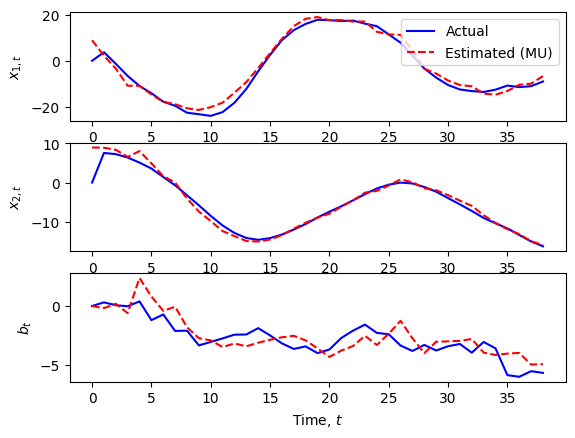

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
# first plot
ax1.plot(z_cache[:-1, 0], 'b-', label='Actual')
ax1.plot(z_mu_cache[:, 0], 'r--', label='Estimated (MU)')
ax1.set_ylabel('$x_{1, t}$')
ax1.legend(loc='upper right')
# second plot
ax2.plot(z_cache[:-1, 1], 'b-', label='Actual')
ax2.plot(z_mu_cache[:, 1], 'r--', label='Estimated (MU)')
ax2.set_ylabel('$x_{2, t}$')
# third plot: b
ax3.plot(z_cache[:-1, 2], 'b-', label='Actual')
ax3.plot(z_mu_cache[:, 2], 'r--', label='Estimated (MU)')
ax3.set_ylabel('$b_t$')
ax3.set_xlabel('Time, $t$')
plt.show()

## 3. System with input

Consider the system
$$\begin{align*}
x_{t+1} {}={} & Ax_t + Bu_t + w_t, \\
y_t {}={}     & Cx_t + v_t.
\end{align*}$$
We assume that the input, $u_t$, is known at time $t$ without error. We can derive the KF equations, which are
$$\begin{align*}
\text{M/U}   &
\left[
\begin{array}{l}
    \hat{x}_{t{}\mid{}t}
    {}={}
    \hat{x}_{t{}\mid{}t-1}
    {}+{}
    \Sigma_{t{}\mid{}t-1}C^\intercal
    (C\Sigma_{t{}\mid{}t-1}C^\intercal + R)^{-1}(y_t - C\hat{x}_{t{}\mid{}t-1})
    \\
    \Sigma_{t{}\mid{}t}
    {}={}
    \Sigma_{t{}\mid{}t-1}
    {}-{}
    \Sigma_{t{}\mid{}t-1}C^\intercal
    (C\Sigma_{t{}\mid{}t-1}C^\intercal + R)^{-1}
    C\Sigma_{t{}\mid{}t-1}
\end{array}
\right.
\\
\text{T/U}   &
\left[
\begin{array}{l}
    \hat{x}_{t+1{}\mid{}t}
    {}={}
    A \hat{x}_{t{}\mid{}t} {} \textcolor{red}{{}+ Bu_{t}}
    \\
    \Sigma_{t+1{}\mid{}t}
    {}={}
    A \Sigma_{t{}\mid{}t} A^\intercal + Q
\end{array}
\right.
\\
\text{Init.} &
\left[
\begin{array}{l}
    \hat{x}_{0{}\mid{}-1}
    {}={}
    \tilde{x}_0
    \\
    \Sigma_{0{}\mid{}-1}
    {}={}
    P_0
\end{array}
\right.
\end{align*}$$

**Exercise:** Derive the KF equations for the above system.

### 3.1. Example
Consider the system
$$\begin{aligned}
x_{t+1} =& \begin{bmatrix}0.98& -0.7 \\ 0.1& 0.9\end{bmatrix}x_t + \begin{bmatrix}1 \\ 0\end{bmatrix}u_t + w_t,
\\
y_t =& \begin{bmatrix}1 & 1\end{bmatrix}x_t + v_t,
\end{aligned}$$
where $w_t$ and $v_t$ satisfy the standard assumptions of the Kalman filter with covariances $Q$ and $R$, respectively, given by
$$Q = \begin{bmatrix}0.2& 0.005 \\ 0.005 & 0.001\end{bmatrix}, R = 10.$$
It is given that $\tilde{x}_0 = (0, 0)$, $P_0 = 100\cdot I$.
Suppose that $u_t = \sin(0.1 t)$.


In [12]:
# Problem data
A = np.array([[0.98, -0.7],
              [0.1, 0.9]])
B = np.array([[1, 0]]).T
C = np.array([[1, 1]])
Q = np.array([[0.2, 0.005],
              [0.005, 0.001]])
R = 10
x0_tilde = np.zeros((2, ))
P0 = 100 * np.eye(2)

we can now construct the functions `time_update` and `measurement_update`

In [13]:
def measurement_update(sigma_tu, x_tu, y):
    z = C @ sigma_tu @ C.T + R # auxiliary variable
    x_mu = x_tu + sigma_tu @ C.T @ np.linalg.solve(z, y - C@x_tu)
    sigma_mu = sigma_tu - sigma_tu @ C.T @ np.linalg.solve(z, C@sigma_tu)
    return sigma_mu, x_mu

def time_update(sigma_mu, x_mu, u):
    x_tu = A @ x_mu + u * B # u is a scalar
    sigma_tu = A @ sigma_mu @ A.T + Q
    return sigma_tu, x_tu

and we can run simulations with the KF

In [14]:
n_sim = 50

x = np.random.multivariate_normal(x0_tilde, P0, 1).T # random initial state
sigma_tu, x_tu = P0, x0_tilde.reshape((2, 1)) # initialisation

x_cache = np.zeros((n_sim, 2))
x_mu_cache = np.zeros((n_sim-1, 2))
x_cache[0, :] = x0_tilde.T
for t in range(n_sim - 1):
    # i. Obtain measurement
    v = np.random.normal([0], np.sqrt(R), 1)
    y = C @ x + v

    # ii. Measurement update
    sigma_mu, x_mu = measurement_update(sigma_tu, x_tu, y)
    x_mu_cache[t, :] = x_mu.T

    # iii. Time update
    u = np.sin(0.1 * t)
    sigma_tu, x_tu = time_update(sigma_mu, x_mu, u)
    w = np.random.multivariate_normal([0, 0], Q, 1).T

    # iv. System dynamics
    x = A @ x + u * B + w
    x_cache[t+1, :] = x.T

and we can plot the results...

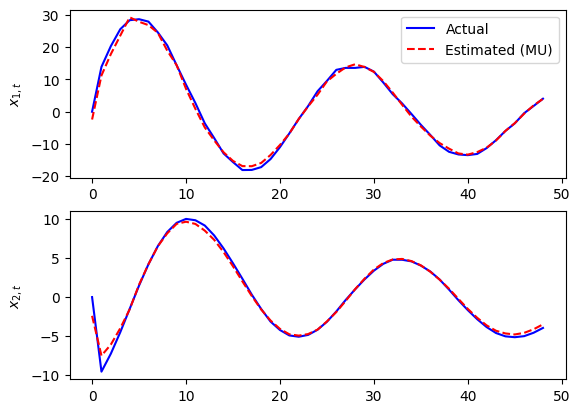

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1)
# first plot
ax1.plot(x_cache[:-1, 0], 'b-', label='Actual')
ax1.plot(x_mu_cache[:, 0], 'r--', label='Estimated (MU)')
ax1.set_ylabel('$x_{1, t}$')
ax1.legend(loc='upper right')
# second plot
ax2.plot(x_cache[:-1, 1], 'b-', label='Actual')
ax2.plot(x_mu_cache[:, 1], 'r--', label='Estimated (MU)')
ax2.set_ylabel('$x_{2, t}$')
plt.show()

## 4. System with input which is imperfectly known

Suppose we can measure $u^{\rm meas}_t = u_t + n_t,$ where $n_t \overset{\rm iid}{\sim}\mathcal{N}(0, N)$. Then,
$$\begin{align*}
    x_{t+1} {}={} & Ax_t + B(u^{\rm meas}_t - n_t) + w_t, \\
    y_t {}={}     & Cx_t + v_t.
\end{align*}$$
We can rewrite this as
$$\begin{align*}
    x_{t+1} {}={} & Ax_t + Bu^{\rm meas}_t - Bn_t + w_t
    \\
    =             & Ax_t + Bu^{\rm meas}_t + \begin{bmatrix}-B & I\end{bmatrix}\begin{bmatrix}n_t\\w_t\end{bmatrix},
    \\
    y_t {}={}     & Cx_t + v_t.
\end{align*}$$
This is in the form we encountered in Section 3 (system with known input).

### 4.1. Example

Consider the system of Section 3, but suppose that the input is measured with zero-mean iid Gaussian noise, $n_t$, with variance $1.5$. Let us design a KF.

In [16]:
# Problem data
A = np.array([[0.98, -0.7],
              [0.1, 0.9]])
B = np.array([[1, 0]]).T
C = np.array([[1, 1]])
Q = np.array([[0.2, 0.005],
              [0.005, 0.001]])
Qu = 1.5
Qbar = sp.linalg.block_diag(Qu, Q) # variance of (n_t, w_t)
R = 10
x0_tilde = np.zeros((2, ))
P0 = 100 * np.eye(2)
G = np.block([[-B, np.eye(2)]])

The time/measurement updates are

In [17]:
def measurement_update(sigma_tu, x_tu, y):
    z = C @ sigma_tu @ C.T + R # auxiliary variable
    x_mu = x_tu + sigma_tu @ C.T @ np.linalg.solve(z, y - C@x_tu)
    sigma_mu = sigma_tu - sigma_tu @ C.T @ np.linalg.solve(z, C@sigma_tu)
    return sigma_mu, x_mu

def time_update(sigma_mu, x_mu, u_meas):
    x_tu = A @ x_mu + u_meas * B # u_meas is a scalar
    sigma_tu = A @ sigma_mu @ A.T + G @ Qbar @ G.T
    return sigma_tu, x_tu

We can now run simulations with the proposed KF...

In [18]:
n_sim = 50

x = np.random.multivariate_normal(x0_tilde, P0, 1).T # random initial state
sigma_tu, x_tu = P0, x0_tilde.reshape((2, 1)) # initialisation

x_cache = np.zeros((n_sim, 2))
x_mu_cache = np.zeros((n_sim-1, 2))
x_cache[0, :] = x0_tilde.T
for t in range(n_sim - 1):
    # i. Obtain measurement
    v = np.random.normal([0], np.sqrt(R), 1)
    y = C @ x + v

    # ii. Measurement update
    sigma_mu, x_mu = measurement_update(sigma_tu, x_tu, y)
    x_mu_cache[t, :] = x_mu.T

    # iii. Time update
    u = np.sin(0.1 * t)
    n = np.random.normal([0], np.sqrt(Qu), 1)
    u_meas = u + n
    sigma_tu, x_tu = time_update(sigma_mu, x_mu, u_meas)
    w = np.random.multivariate_normal([0, 0], Q, 1).T

    # iv. System dynamics
    x = A @ x + u * B + w
    x_cache[t+1, :] = x.T

...and, lastly, we can plot the results...

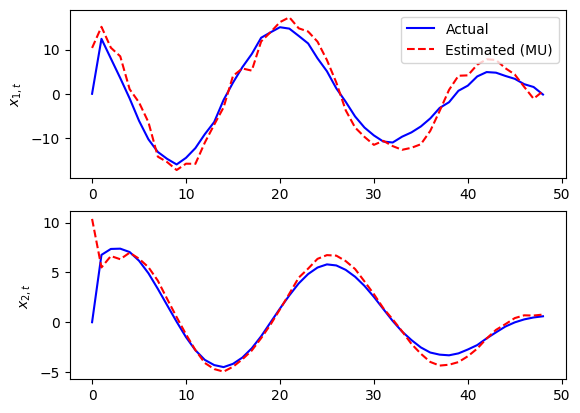

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1)
# first plot
ax1.plot(x_cache[:-1, 0], 'b-', label='Actual')
ax1.plot(x_mu_cache[:, 0], 'r--', label='Estimated (MU)')
ax1.set_ylabel('$x_{1, t}$')
ax1.legend(loc='upper right')
# second plot
ax2.plot(x_cache[:-1, 1], 'b-', label='Actual')
ax2.plot(x_mu_cache[:, 1], 'r--', label='Estimated (MU)')
ax2.set_ylabel('$x_{2, t}$')
plt.show()

## 5. Not independent noises

Let us assume that $w_t$ and $v_t$ are not mutually independent, but
$$\begin{bmatrix}w_t \\ v_t\end{bmatrix} \overset{\text{iid}}{\sim} \mathcal{N}\left(0, \begin{bmatrix}Q & S \\ S^\intercal & R\end{bmatrix} \right).$$
For notational convenience we will use the notation ${\rm I\!E}_{t}[{}\cdot{}] \coloneqq {\rm I\!E}[{}\cdot{} {}\mid{} y_0, \ldots, y_t].$ Likewise, we define ${\rm Var}_t[{}\cdot{}] = {\rm Var}[{}\cdot{} {}\mid{} y_0, \ldots, y_t]$ and ${\rm Cov}_t({}\cdot{}, {}\cdot{}) = {\rm Cov}({}\cdot{}, {}\cdot{} {}\mid{} y_0, \ldots, y_t)$. Recall that
1. $\hat{x}_{t{}\mid{} t} \coloneqq {\rm I\!E}_{t}[x_t]$,
2. $\hat{x}_{t{}\mid{} t-1} \coloneqq {\rm I\!E}_{t-t}[x_t]$,
3. $\Sigma_{t{}\mid{}t} {}\coloneqq{} {\rm Var}_t[x_t]$, and
4. $\Sigma_{t{}\mid{}t-1} \coloneqq {\rm Var}_{t-1}[x_t]$.

### 5.1. Revision of assumptions

For the sake of completeness, let us state all assumptions:
1. $(w_t, v_t)$ is jointly normal and iid
2. $x_0\sim \mathcal{N}(\tilde{x}_0, P_0)$
3. $x_0$ is independent of the process and measurement noise

### 5.1. Derivation of KF equations

**Task 1 (measurement update):** Show that
$$\left.\begin{pmatrix}x_t\\y_t\end{pmatrix}\right|{}y_0, \ldots, y_{t-1} \sim \mathcal{N}\left(\begin{bmatrix}\hat{x}_{t\mid t-1} \\ C\hat{x}_{t\mid t-1} \end{bmatrix}, \begin{bmatrix}\Sigma_{t\mid t-1} & \Sigma_{t\mid t-1}C^\intercal \\C\Sigma_{t\mid t-1} & C\Sigma_{t\mid t-1}C^\intercal + R\end{bmatrix}\right).$$
We initialise $\hat{x}_{0\mid -1} = ?$ and $\Sigma_{0\mid -1} = ?$.

**Task 2  (measurement update):** Determine $\hat{x}_{t\mid t}$ and $\Sigma_{t\mid t}$ by applying the Gaussian conditioning theorem.

**Task 3:** $w_t$ and $v_t$ are not independent. Since $y_t$ depends on $v_t$ we conclude that $w_t$ and $y_t$ are not independent. We *cannot*, therefore, say that "${\rm I\!E}_t[w_t] = 0$". Instead, we need to determine the joint distribution of $(w_t, y_t)$ given $y_0, \ldots, y_{t-1}$. We will need this in Tasks 4 and 5.

We have
1. ${\rm I\!E}_{t-1}[w_t] = ?$
2. ${\rm I\!E}_{t-1}[y_t] = {\rm I\!E}_{t-1}[Cx_t+v_t] = ?$
3. ${\rm Var}_{t-1}[w_t] = ?$
4. ${\rm Var}_{t-1}[y_t] = {\rm Var}_{t-1}[Cx_t+v_t] = ?$
5. ${\rm Cov}_{t-1}(w_t, y_t) = {\rm Cov}_{t-1}[w_t, Cx_t + v_t] = ?$

We conclude that
$$\left.\begin{pmatrix}w_t\\y_t\end{pmatrix}\right|{}y_0, \ldots, y_{t-1} \sim \mathcal{N}\left(\begin{bmatrix}0 \\ C\hat{x}_{t\mid t-1} \end{bmatrix}, \begin{bmatrix}? & ? \\? & ?\end{bmatrix}\right).$$



**Task 4:** Based on the result of Task 3, determine $w_t {}\mid{} y_{0}, \ldots, y_{t}$ (apply the Gaussian conditioning theorem). This is similar to what you did in Task 2.

**Task 5 (time update):** Predict the next state, i.e., determine $\hat{x}_{t+1\mid t} = {\rm I\!E}_t[x_{t+1}]$ and $\Sigma_{t+1 \mid t} = {\rm Var}_t[x_{t+1}]$. You will need to use the result from Task 4.

**Task 6:** Summarise the KF equations.

## 5.2. Simulations


In [ ]:
## Your code goes here